# Problem Definition

A worldwide e-commerce site has localized versions of the site in Spanish. Managers noticed that Spain-based users have a much higher conversion rate than any other Spanish-speaking country. After talking to the international team in charge of Spain And Latin America(LatAm) about it, the Spain and LatAm country manager suggested that one reason could be translation. All Spanish- speaking countries originally had the same translation of the site which was written by a translator from Spain.

- Confirm that the test is actually negative. That is, it appears that the old version of the site with just one translation - across Spain and LatAm performs better
- Explain why that might be happening. Are the localized translations really worse?
- If you identified what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and the results can be trusted.

Refer to [JifuZhao](https://github.com/JifuZhao/DS-Take-Home/blob/master/02.%20Spanish%20Translation%20AB%20Test.ipynb) and
[tana](https://github.com/tana777/ds-take-home-challenge/blob/master/02.Spanish_Translation_AB_Test.ipynb) work

# import libraries and data

In [121]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns
import os
sns.set_style("white")
os.getcwd()
from scipy.stats import ttest_ind

In [122]:
test = pd.read_csv('test_table.csv')

In [123]:
test.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [124]:
user = pd.read_csv('user_table.csv')
user.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


# Exploratory Data Analysis (EDA)
A few things we need to do before we dive into predictions:
Check the missing values
Check the outlier
Plot the distribution for numeric and categorical values

In [125]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453321 entries, 0 to 453320
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           453321 non-null  int64 
 1   date              453321 non-null  object
 2   source            453321 non-null  object
 3   device            453321 non-null  object
 4   browser_language  453321 non-null  object
 5   ads_channel       181877 non-null  object
 6   browser           453321 non-null  object
 7   conversion        453321 non-null  int64 
 8   test              453321 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 31.1+ MB


In [126]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452867 entries, 0 to 452866
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  452867 non-null  int64 
 1   sex      452867 non-null  object
 2   age      452867 non-null  int64 
 3   country  452867 non-null  object
dtypes: int64(2), object(2)
memory usage: 13.8+ MB


In [127]:
test.isnull().sum()

user_id                  0
date                     0
source                   0
device                   0
browser_language         0
ads_channel         271444
browser                  0
conversion               0
test                     0
dtype: int64

### Check the outlier

In [128]:
test.describe()

,user_id,conversion,test
count,453321.000000,453321.000000,453321.000000
mean,499937.514728,0.049579,0.476446
std,288665.193436,0.217073,0.499445
min,1.000000,0.000000,0.000000
25%,249816.000000,0.000000,0.000000
50%,500019.000000,0.000000,0.000000
75%,749522.000000,0.000000,1.000000
max,1000000.000000,1.000000,1.000000


In [129]:
#Discover and visualize the data to gain insights
print('Variable', '   ', 'count of unique value','  ', 'content')
for column in test.columns:
    uniques = test[column].unique()
    print('{0:20s} {1:4d}\t'.format(column, len(uniques)), uniques[:7])   

Variable     count of unique value    content
user_id              453321	 [315281 497851 848402 290051 548435 540675 863394]
date                    5	 ['2015-12-03' '2015-12-04' '2015-11-30' '2015-12-01' '2015-12-02']
source                  3	 ['Direct' 'Ads' 'SEO']
device                  2	 ['Web' 'Mobile']
browser_language        3	 ['ES' 'Other' 'EN']
ads_channel             6	 [nan 'Google' 'Facebook' 'Bing' 'Yahoo' 'Other']
browser                 7	 ['IE' 'Chrome' 'Android_App' 'FireFox' 'Iphone_App' 'Safari' 'Opera']
conversion              2	 [1 0]
test                    2	 [0 1]


In [130]:
#Discover and visualize the data to gain insights
print('Variable', '   ', 'count of unique value','  ', 'content')
for column in user.columns:
    uniques = user[column].unique()
    print('{0:20s} {1:4d}\t'.format(column, len(uniques)), uniques[:4])   

Variable     count of unique value    content
user_id              452867	 [765821 343561 118744 987753]
sex                     2	 ['M' 'F']
age                    52	 [20 27 23 29]
country                17	 ['Mexico' 'Nicaragua' 'Colombia' 'Venezuela']


In [131]:
# Check uniqueness
#print('Test ID:\t', len(test['user_id'].unique()), '\t', len(test['user_id'].unique()) == len(test))

print('Test table Unique User Ids:\t', len(test['user_id'].unique()), '\t', 
      len(test['user_id'].unique()) == len(test['user_id']))
print('User table Unique User Ids:\t', len(user['user_id'].unique()),'\t',
      len(user['user_id'].unique())== len(user['user_id']))

Test table Unique User Ids:	 453321 	 True
User table Unique User Ids:	 452867 	 True



It is clear that two tables do not have repeated users and for some users in the test set, we miss their information about sex, age and country. Thus, when joining, we have to guarantee the compeleteness of user ids in the test table. I am planning to let user table to left join test table.

# Q1. Confirm that the test is actually negative

In [132]:
# Merge two tables and use left join
data=pd.merge(test,user,how='left',on='user_id')
data

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32.0,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21.0,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34.0,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22.0,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19.0,Mexico
...,...,...,...,...,...,...,...,...,...,...,...,...
453316,425010,2015-12-04,SEO,Web,ES,NaN,FireFox,0,0,M,50.0,Mexico
453317,826793,2015-12-01,SEO,Mobile,ES,NaN,Android_App,0,1,F,20.0,Colombia
453318,514870,2015-12-02,Ads,Mobile,ES,Bing,Android_App,0,0,M,25.0,Spain
453319,785224,2015-12-04,SEO,Mobile,ES,NaN,Android_App,0,1,M,21.0,Colombia


### Check if the spanish has high conversion rate

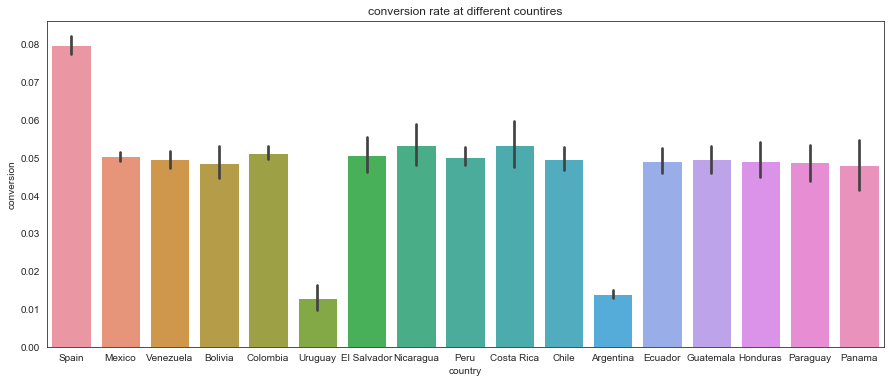

In [133]:
plt.subplots(1,1,figsize=(15,6))
sns.barplot(data['country'], data['conversion'], data=data)
plt.title('conversion rate at different countires')
plt.show()

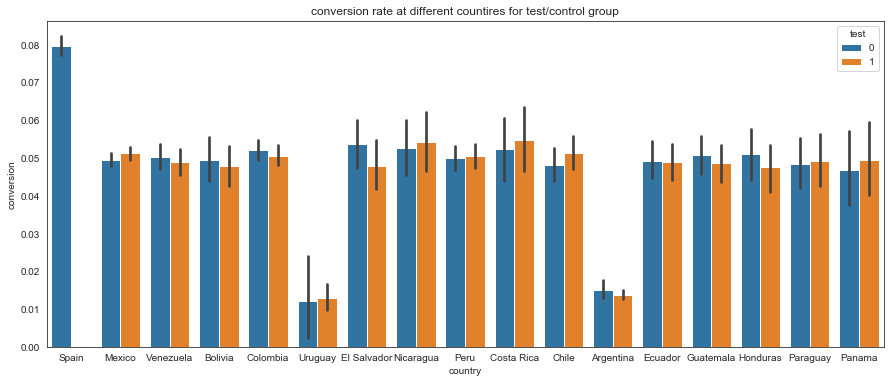

In [134]:
plt.subplots(1,1,figsize=(15,6))
sns.barplot(data['country'], data['conversion'], hue='test', data=data)
plt.title('conversion rate at different countires for test/control group')
plt.show()

### Obviously, Spain does have the highest mean conversion rate among all countries. Now I am trying to confirm that the test is negative by using t test.

In [135]:
# Determine dataset
data_goal = data[data['country']!='Spain'] # We will not include users based in Spain because nothing changed here.
control_data = data_goal[data_goal['test']==0]
test_data = data_goal[data_goal['test']==1]

In [136]:
print('Mean conversion rate of control group','\t' ,control_data['conversion'].values.mean())
print('Mean conversion rate of test group', '\t', test_data['conversion'].values.mean())

Mean conversion rate of control group 	 0.04833042316066309
Mean conversion rate of test group 	 0.043424713982118966


[t_test explanation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html)

In [137]:
print(ttest_ind(control_data['conversion'].values, test_data['conversion'].values, equal_var = False))

Ttest_indResult(statistic=7.3939374121344805, pvalue=1.4282994754055316e-13)


- Since the p value is less than 0.05 threshold, we may reject the null hypothesis and say that the test is actually negative except the case of bias experiment design or not enough data.

- We can see that control group without changing translation has a converting at 4.8%, however, users in test group with localized translation just convert at 4.3%. It does have a negative effect for changing translation.



# Q2. Explain why that might be happening. Are the localized translations really worse?

### 2.1 Date distribution

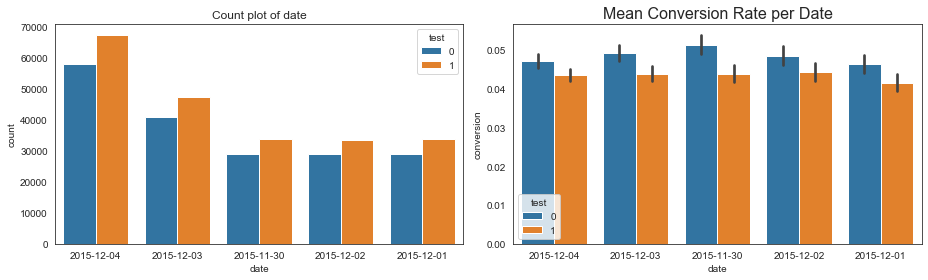

In [138]:
# date variable visualization
fig, ax = plt.subplots(1,2,figsize=(13,4))
sns.countplot(data_goal ['date'],hue='test', data=data_goal , ax=ax[0])
ax[0].set_title('Count plot of date',fontsize=12)

sns.barplot(x='date', y='conversion', hue='test', data=data_goal , ax=ax[1])
ax[1].set_title('Mean Conversion Rate per Date', fontsize=16)

plt.tight_layout()
plt.show()

### 2.2 Source distribution

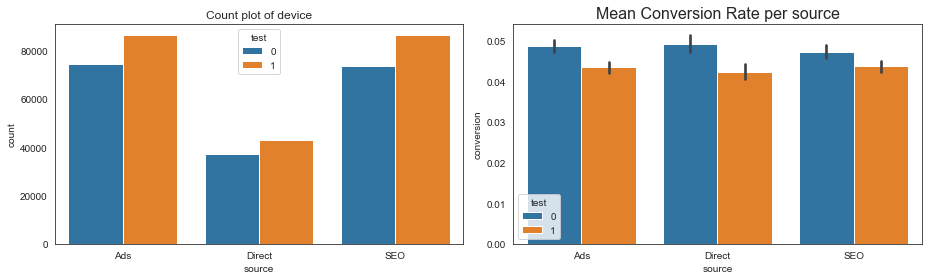

In [139]:
# Source variable visualization
fig, ax = plt.subplots(1,2,figsize=(13,4))
sns.countplot(data_goal ['source'],hue='test', data=data_goal , ax=ax[0])
ax[0].set_title('Count plot of device',fontsize=12)

sns.barplot(x='source', y='conversion', hue='test', data=data_goal , ax=ax[1])
ax[1].set_title('Mean Conversion Rate per source', fontsize=16)

plt.tight_layout()
plt.show()

### 2.3 Device distribution

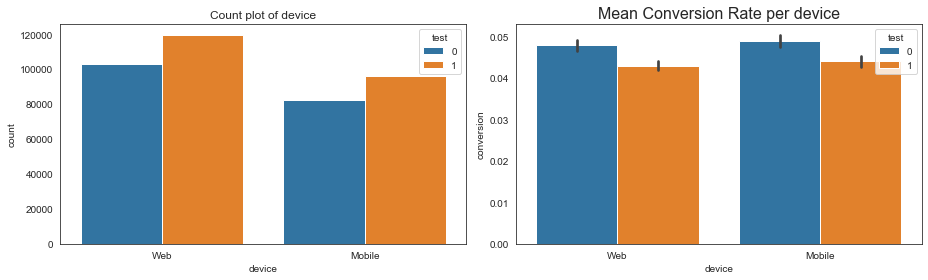

In [140]:
# Device variable visualization
fig, ax = plt.subplots(1,2,figsize=(13,4))
sns.countplot(data_goal['device'],hue='test', data=data_goal , ax=ax[0])
ax[0].set_title('Count plot of device',fontsize=12)

sns.barplot(x='device', y='conversion', hue='test', data=data_goal, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per device', fontsize=16)

plt.tight_layout()
plt.show()

### 2.4 Browser Language distribution

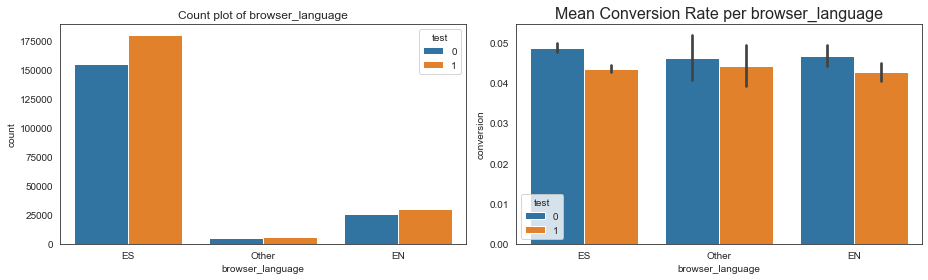

In [141]:
# Browser Language variable visualization
fig, ax = plt.subplots(1,2,figsize=(13,4))
sns.countplot(data_goal['browser_language'],hue='test', data=data_goal , ax=ax[0])
ax[0].set_title('Count plot of browser_language',fontsize=12)

sns.barplot(x='browser_language', y='conversion', hue='test', data=data_goal, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per browser_language', fontsize=16)

plt.tight_layout()
plt.show()

### 2.5 ads_channel distribution

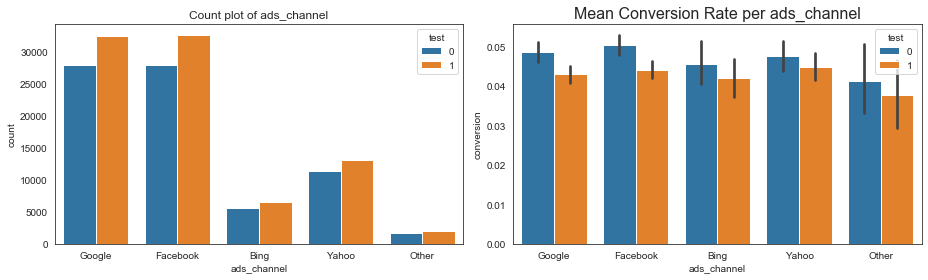

In [142]:
# ads_channel variable visualization
fig, ax = plt.subplots(1,2,figsize=(13,4))
sns.countplot(data_goal['ads_channel'],hue='test', data=data_goal , ax=ax[0])
ax[0].set_title('Count plot of ads_channel',fontsize=12)

sns.barplot(x='ads_channel', y='conversion', hue='test', data=data_goal, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per ads_channel', fontsize=16)

plt.tight_layout()
plt.show()

### 2.6 browser distribution

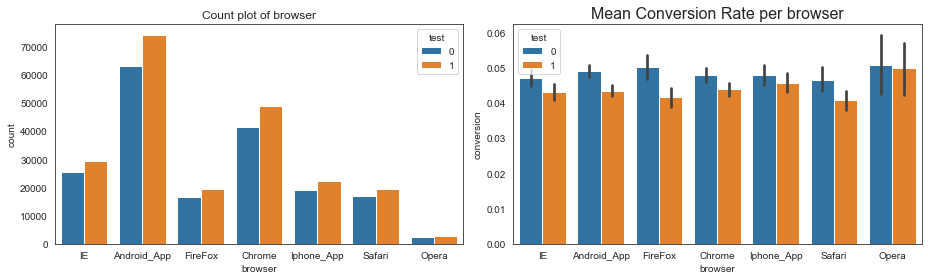

In [143]:
# browser variable visualization
fig, ax = plt.subplots(1,2,figsize=(13,4))
sns.countplot(data_goal['browser'],hue='test', data=data_goal , ax=ax[0])
ax[0].set_title('Count plot of browser',fontsize=12)

sns.barplot(x='browser', y='conversion', hue='test', data=data_goal, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per browser', fontsize=16)

plt.tight_layout()
plt.show()

### 2.7 sex variable distribution

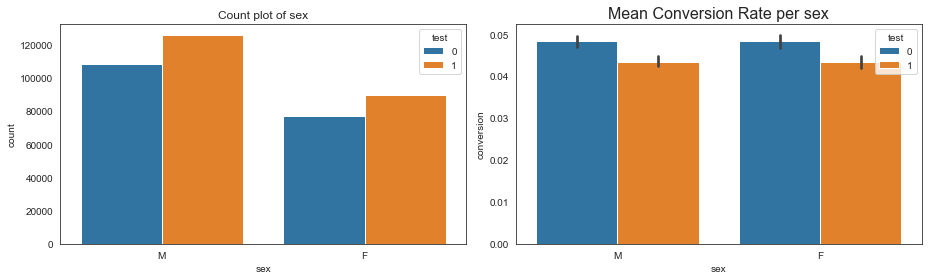

In [144]:
# sex variable visualization
fig, ax = plt.subplots(1,2,figsize=(13,4))
sns.countplot(data_goal['sex'],hue='test', data=data_goal , ax=ax[0])
ax[0].set_title('Count plot of sex',fontsize=12)

sns.barplot(x='sex', y='conversion', hue='test', data=data_goal, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per sex', fontsize=16)

plt.tight_layout()
plt.show()

### 2.8 age variable distribution

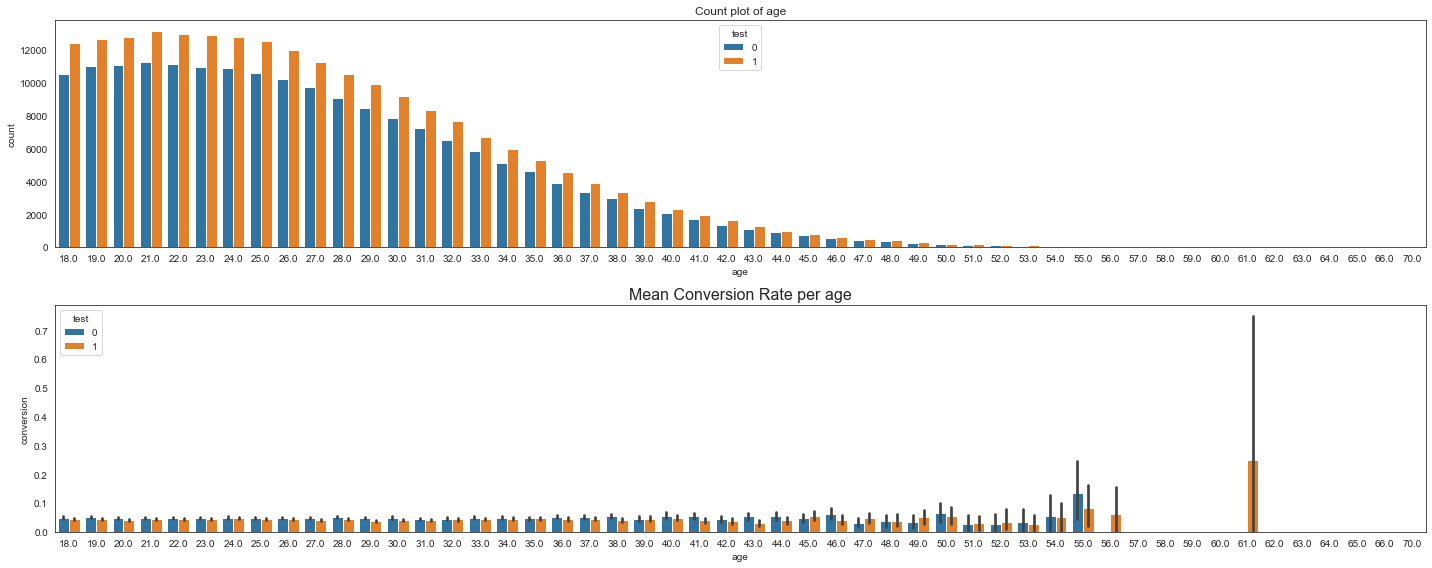

In [145]:
# age variable visualization
fig, ax = plt.subplots(2,1,figsize=(20,8))
sns.countplot(data_goal['age'],hue='test', data=data_goal , ax=ax[0])
ax[0].set_title('Count plot of age',fontsize=12)

sns.barplot(x='age', y='conversion', hue='test', data=data_goal, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per age', fontsize=16)

plt.tight_layout()
plt.show()

### 2.9 date lineplot distribution

Text(0.5, 1.0, 'Date vs Mean conversion rate')

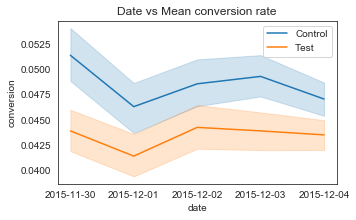

In [146]:
plt.subplots(1,1,figsize=(5,3))
sns.lineplot(x='date',y='conversion',data=control_data,err_style='band',label='Control')
sns.lineplot(x='date',y='conversion',data=test_data,err_style='band',label='Test')
plt.legend()
plt.title('Date vs Mean conversion rate')

I am evaluating each variable except for country based on control and test group, what I find is that:

1. For source, device, browser_language, ads_channel, browser, sex and age variables, there's no obvious differece between two groups and they both follow the same pattern.
2. Test has constantly been worse than control and there is relatively little variance across days. That
probably means that we do have enough data, but there was some bias in the experiment set up. Consequently, test period of five days might probably detect nothing about true effect of changing translation. I think the sensible test time should be 2 weeks which can help teams identify the true pattern.

Next step I am planning to break down country variable and check mean conversion rate for each country on control and test group, respectively.

### Country distribution

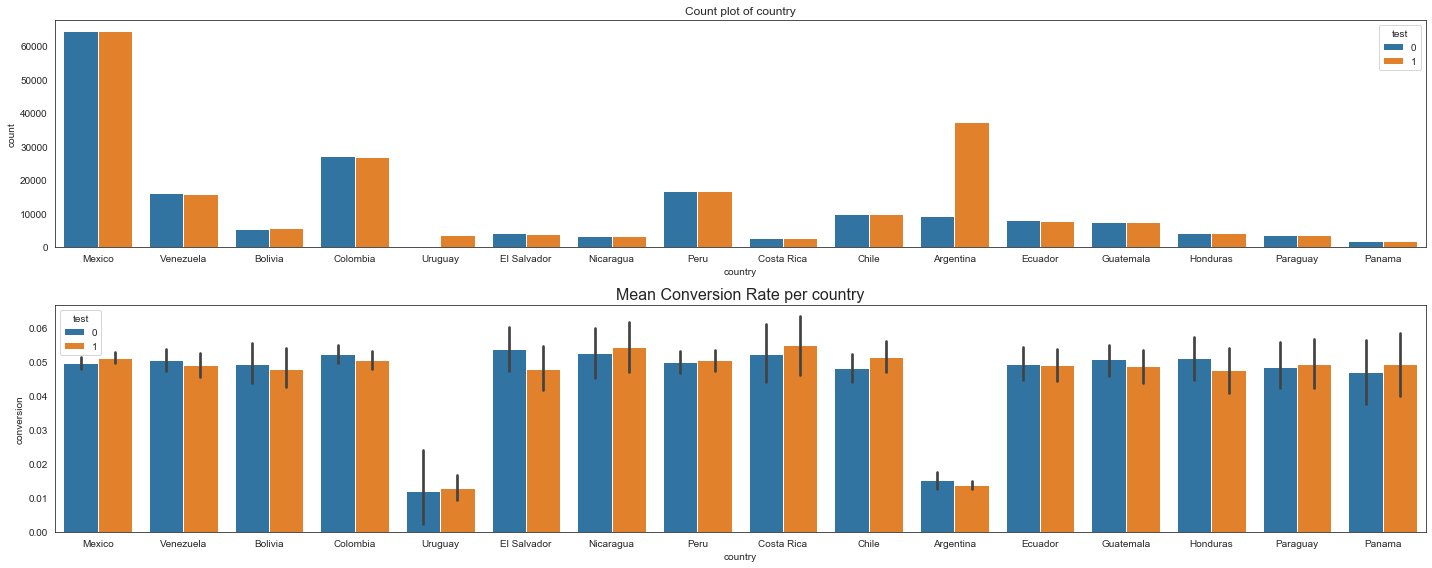

In [147]:
# Country variable visualization
fig, ax = plt.subplots(2,1,figsize=(20,8))
sns.countplot(data_goal['country'],hue='test', data=data_goal , ax=ax[0])
ax[0].set_title('Count plot of country',fontsize=12)

sns.barplot(x='country', y='conversion', hue='test', data=data_goal, ax=ax[1])
ax[1].set_title('Mean Conversion Rate per country', fontsize=16)

plt.tight_layout()
plt.show()

From coutry variable plots, it is clear that there are two contries, Uruguay and Argentina, that their control and test group have different number of users, which is not acceptable due to other countries all keep the 50/50 pattern. I think what fraction of visitors you want to be in control or test group should keep consistent on each level. Further, although the overall conversion rate of control is over that of test, we find that it is not right for each Spanish speaking country, which indicates changing to localized translation might be essentially not bad. Thus, it is worth doing a t test here.

In [148]:
print('{0:15s} {1:>15s} {2:>17s} {3:>12s} {4:>23s}'.format('Country', 'Mean of Control', 'Mean of Test', 'P-Value', 'No.Control/No.Test'))
print('-' * 85)
p=[]
for country in data_goal['country'].dropna().unique():
    data_country = data_goal[data_goal['country']==country]
    cont_country = data_country[data_country['test']==0].conversion.values
    test_country = data_country[data_country['test']==1].conversion.values
    p_value=ttest_ind(cont_country, test_country, equal_var=False).pvalue
    p.append(p_value)
    ratio = len(cont_country)/len(test_country)
    print('{0:15s} {1:10.5f} {2:20.5f} {3:15f} {4:15.2f}'.format(country,cont_country.mean(),test_country.mean(),p_value,ratio))

Country         Mean of Control      Mean of Test      P-Value      No.Control/No.Test
-------------------------------------------------------------------------------------
Mexico             0.04949              0.05119        0.165544            1.00
Venezuela          0.05034              0.04898        0.573702            1.02
Bolivia            0.04937              0.04790        0.718885            1.00
Colombia           0.05209              0.05057        0.423719            1.00
Uruguay            0.01205              0.01291        0.879764            0.11
El Salvador        0.05355              0.04795        0.248127            1.01
Nicaragua          0.05265              0.05418        0.780400            1.03
Peru               0.04991              0.05060        0.771953            1.00
Costa Rica         0.05226              0.05474        0.687876            1.00
Chile              0.04811              0.05130        0.302848            1.00
Argentina          0.01507 

## Q3. If you identified what was wrong, design an algorithm that would return FALSE if the same problem is happening in the future and TRUE if everything is good and the results can be trusted.

The process we try to identify what was wrong tells us the main problem is about country variable. Our design for users in control or test group are not even on some countries, which might lead to noise for our experiment. Further, when calibrating the model on each country level, the result is not significant anymore. Thus, I tend to design an algorithm to sanity check problem about country, like if users are evenly divided into control and test groups, or if the result is significant on each country.

In [149]:
def sanitycheck(data,error):
    # no need to include users in Spain
    data = data[data['country']!='Spain']
    country_name = data['country'].dropna().unique()
    sig_country=[]
    print('{0:15s} {1:>15s} {2:>17s} {3:>12s} {4:>23s}'.
          format('Country', 'Mean of Control','Mean of Test', 'P-Value', 'No.Control/No.Test'))
    print('-' * 85)
    # check each country
    for country in country_name:
        data_country = data[data['country']==country]
        # split into control and test group
        cont_country = data_country[data_country['test']==0].conversion.values
        test_country = data_country[data_country['test']==1].conversion.values
        p_value=ttest_ind(cont_country, test_country, equal_var=False).pvalue
        if p_value < error:
            sig_country.append(country)
        ratio = len(cont_country)/len(test_country)
        print('{0:15s} {1:10.5f} {2:20.5f} {3:15f} {4:15.2f}'.
              format(country,cont_country.mean(),test_country.mean(),p_value,ratio))
    if len(sig_country)==len(country_name):
        print('Everything is good and the result can be trusted!')
        return('TRUE')
    else:
        print('There is at least something wrong among one of countries, its result is not significant. Please check.' )
        return('FALSE')

In [150]:
sanitycheck(data_goal,0.05)

Country         Mean of Control      Mean of Test      P-Value      No.Control/No.Test
-------------------------------------------------------------------------------------
Mexico             0.04949              0.05119        0.165544            1.00
Venezuela          0.05034              0.04898        0.573702            1.02
Bolivia            0.04937              0.04790        0.718885            1.00
Colombia           0.05209              0.05057        0.423719            1.00
Uruguay            0.01205              0.01291        0.879764            0.11
El Salvador        0.05355              0.04795        0.248127            1.01
Nicaragua          0.05265              0.05418        0.780400            1.03
Peru               0.04991              0.05060        0.771953            1.00
Costa Rica         0.05226              0.05474        0.687876            1.00
Chile              0.04811              0.05130        0.302848            1.00
Argentina          0.01507 

'FALSE'